# MNIST notebook

## import libraries

In [154]:
import os
# Set TensorFlow logging to only show errors
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # This silences INFO and WARNING messages
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Add, Dense, Dropout, Embedding, GlobalAveragePooling1D, Input, Layer, LayerNormalization, MultiHeadAttention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy

try:
  import pennylane as qml
except:
  !pip install pennylane
  import pennylane as qml
from pennylane.operation import Operation

## Import the dataset

In [155]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator


In [156]:
import random
# Set the random seeds for reproducibility
random_seed = 40  # You can choose any seed number

# Set the random seed for Python's built-in random module
random.seed(random_seed)

# Set the random seed for NumPy
np.random.seed(random_seed)

# Set the random seed for TensorFlow
tf.random.set_seed(random_seed)

In [157]:
import tensorflow as tf
import numpy as np

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Filter for only the classes 3 and 6
train_filter = np.where((y_train == 6) | (y_train == 3))
test_filter = np.where((y_test == 6) | (y_test == 3))

x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]

# Use the first 500 images as the training set
x_train, y_train = x_train[:500], y_train[:500]
# Randomly sample 300 images from the remaining data as the validation set
x_val, y_val = x_test[500:800], y_test[500:800]

x_test, y_test = x_test[:300], y_test[:300]

# Rescale the images
x_train = x_train / 255.0
x_val = x_val / 255.0
x_test = x_test / 255.0

print("Training set shape:", x_train.shape)
print("Validation set shape:", x_val.shape)
print("Test set shape:", x_test.shape)


Training set shape: (500, 28, 28)
Validation set shape: (300, 28, 28)
Test set shape: (300, 28, 28)


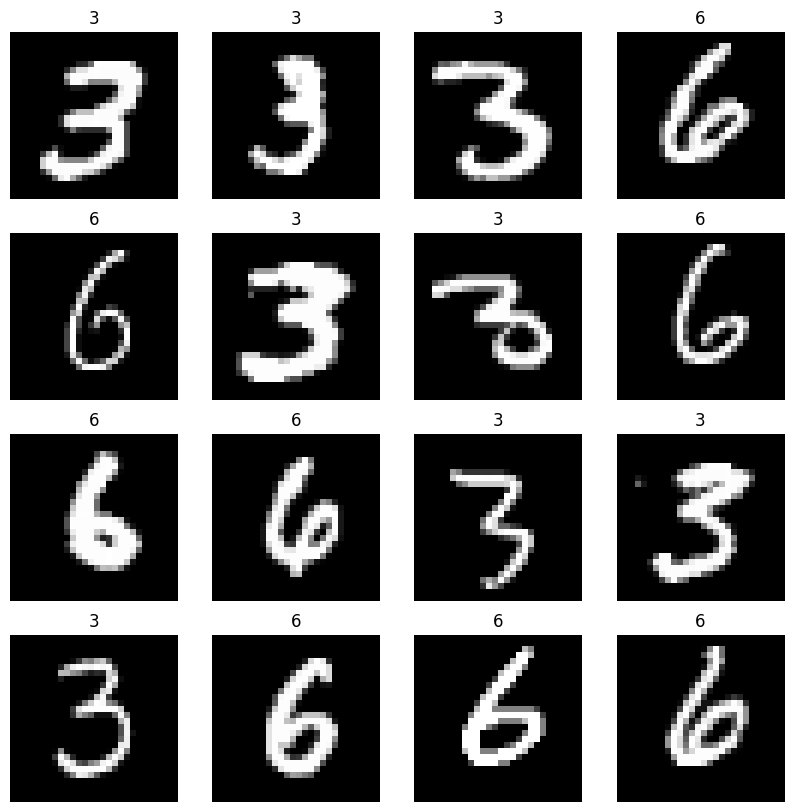

In [158]:
import matplotlib.pyplot as plt

# Plot a random sample of 16 images from the training set
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(y_train[i])  # Assuming y_train contains the class labels
    plt.axis('off')
plt.show()


In [159]:
# Expand the dimensions of the images to (28, 28, 1) to represent the grayscale channel explicitly

train_images = np.expand_dims(x_train, -1)
validation_images = np.expand_dims(x_val, -1)
test_images = np.expand_dims(x_test, -1)

def preprocess_images(images):
    # Center-crop to 24x24
    images_cropped = tf.image.central_crop(images, central_fraction=24/28)
    
    # Down-sample to 4x4
    images_downsampled = tf.image.resize(images_cropped, size=(4, 4), method=tf.image.ResizeMethod.BILINEAR)
    
    return images_downsampled

# Preprocess the train, validation, and test images
train_images_processed = preprocess_images(train_images)
validation_images_processed = preprocess_images(validation_images)
test_images_processed = preprocess_images(test_images)

# Map the labels 3 -> 0 and 6 -> 1
y_train_binary = np.where(y_train == 3, 0, 1)
y_val_binary = np.where(y_val == 3, 0, 1)
y_test_binary = np.where(y_test == 3, 0, 1)

# Convert the labels to one-hot encoded vectors
train_labels = to_categorical(y_train_binary, 2)
validation_labels = to_categorical(y_val_binary, 2)
test_labels = to_categorical(y_test_binary, 2)

print("Shape of train labels:", train_labels.shape)
print("Shape of validation labels:", validation_labels.shape)
print("Shape of test labels:", test_labels.shape)

Shape of train labels: (500, 2)
Shape of validation labels: (300, 2)
Shape of test labels: (300, 2)


In [160]:
unique_labels = np.unique(y_train)
print(f"Unique labels in the training set: {unique_labels}")

Unique labels in the training set: [3 6]


In [161]:
def plot_images(images, labels, num_images=25, figsize=(10,10)):
    grid_size = 5
    plt.figure(figsize=figsize)

    for i in range(num_images):
        plt.subplot(grid_size, grid_size, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap='gray')
        plt.xlabel(f'Label: {labels[i]}')
    plt.show()

## Common Quantum functions

In [162]:
class RBSGate(Operation):
    num_params = 1
    num_wires = 2
    par_domain = 'R'

    def __init__(self, theta, wires):
        super().__init__(theta, wires=wires)
        self.theta = theta

    @staticmethod
    def compute_matrix(theta):
        cos = tf.cos(theta)
        sin = tf.sin(theta)
        return tf.convert_to_tensor([
            [1, 0, 0, 0],
            [0, cos, sin, 0],
            [0, -sin, cos, 0],
            [0, 0, 0, 1]
        ], dtype=tf.float64)

    def adjoint(self):
        return RBSGate(-self.parameters[0], wires=self.wires)

    def label(self, decimals=None, base_label=None, **kwargs):
        theta = self.parameters[0]
        return f"RBS({theta:.2f})"
def convert_array(X):
    alphas = tf.zeros(X.shape[:-1] + (X.shape[-1]-1,), dtype=X.dtype)
    X_normd = tf.linalg.l2_normalize(X, axis=-1)
    for i in range(X.shape[-1]-1):
        prod_sin_alphas = tf.reduce_prod(tf.sin(alphas[..., :i]), axis=-1)
        updated_value = tf.acos(X_normd[..., i] / prod_sin_alphas)
        indices = tf.constant([[i]])
        updates = tf.reshape(updated_value, [1])
        alphas = tf.tensor_scatter_nd_update(alphas, indices, updates)
    return alphas
def vector_loader(alphas, wires=None, is_x=True, is_conjugate=False):
    if wires is None:
        wires = list(range(len(alphas) + 1))
    if is_x and not is_conjugate:
        qml.PauliX(wires=wires[0])
    if is_conjugate:
        for i in range(len(wires) - 2, -1, -1):
            qml.apply(RBSGate(-alphas[i], wires=[wires[i], wires[i+1]]))
    else:
        for i in range(len(wires) - 1):
            qml.apply(RBSGate(alphas[i], wires=[wires[i], wires[i+1]]))
    if is_x and is_conjugate:
        qml.PauliX(wires=wires[0])
def pyramid_circuit(parameters, wires=None):
    if wires is None:
        length = len(qml.device.wires)
    else:
        length = len(wires)

    k = 0

    for i in range(2 * length - 2):
        j = length - abs(length - 1 - i)

        if i % 2:
            for _ in range(j):
                if _ % 2 == 0 and k < (parameters.shape[0]):
                    qml.apply(RBSGate(parameters[k], wires=([wires[_], wires[_ + 1]])))
                    k += 1
        else:
            for _ in range(j):
                if _ % 2 and k < (parameters.shape[0]):
                    qml.apply(RBSGate(parameters[k], wires=([wires[_], wires[_ + 1]])))
                    k += 1

# qOrthNN

In [163]:
class HybridModel(tf.keras.Model):
    def __init__(self):
        super(HybridModel, self).__init__()
        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(6, activation='linear', dtype=tf.float64)
        self.quantum_weights = self.add_weight(
            shape=(15,),
            initializer='zeros',
            trainable=True,
            dtype=tf.float32
        )
        self.dev = qml.device('default.qubit.tf', wires=6)
        # Pruning attributes
        self.accumulated_grads = tf.Variable(tf.zeros_like(self.quantum_weights), trainable=False)
        self.accumulate_window = 6
        self.prune_ratio = 1

        @qml.qnode(self.dev, interface='tf', diff_method='backprop')
        def quantum_circuit(inputs, weights):
            inputs = tf.cast(inputs, tf.float32)
            weights = tf.cast(weights, tf.float32)
            vector_loader(convert_array(inputs), wires=range(6))
            pyramid_circuit(weights, wires=range(6))
            return [qml.expval(qml.PauliZ(wire)) for wire in range(6)]

        self.quantum_circuit = quantum_circuit
        self.classical_nn_2 = tf.keras.layers.Dense(2, activation='softmax', dtype=tf.float64)

    def call(self, inputs):
        inputs = tf.cast(inputs, tf.float64)
        flattened_inputs = self.flatten(inputs)
        classical_output = self.dense(flattened_inputs)
        quantum_outputs = tf.map_fn(
            lambda x: tf.stack(self.quantum_circuit(x, self.quantum_weights)),
            classical_output,
            fn_output_signature=tf.TensorSpec(shape=(6,), dtype=tf.float64)
        )
        # Handle NaN values in quantum outputs
        quantum_outputs = tf.where(tf.math.is_nan(quantum_outputs), tf.zeros_like(quantum_outputs), quantum_outputs)

        # Combine and process quantum outputs through additional NN layers
        quantum_outputs = tf.reshape(quantum_outputs, [-1, 6])
        # nn_output = self.classical_nn_1(quantum_outputs)
        nn_output = self.classical_nn_2(quantum_outputs)

        return nn_output
    def train_step(self, data):
        x, y = data  # Unpack the data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Compute gradients
        gradients = tape.gradient(loss, self.trainable_variables)

        # Find the index of quantum_weights in trainable_variables
        for idx, var in enumerate(self.trainable_variables):
            if var is self.quantum_weights:
                quantum_weights_idx = idx
                break

        # Probabilistic Gradient Pruning
        # Step 1: Accumulate gradients for quantum_weights
        if self.accumulate_window > 0:
            if gradients[quantum_weights_idx] is not None:
                self.accumulated_grads.assign_add(gradients[quantum_weights_idx])
            self.accumulate_window -= 1

            # Apply gradients for other variables (excluding quantum_weights)
            other_gradients = []
            other_variables = []
            for i, (grad, var) in enumerate(zip(gradients, self.trainable_variables)):
                if i != quantum_weights_idx and grad is not None:
                    other_gradients.append(grad)
                    other_variables.append(var)
            self.optimizer.apply_gradients(zip(other_gradients, other_variables))
        else:
            # Step 2: Prune weights of quantum_weights
            # Normalize the accumulated gradients
            grad_min = tf.reduce_min(self.accumulated_grads)
            grad_max = tf.reduce_max(self.accumulated_grads)
            epsilon = 1e-8
            norm_grads = (self.accumulated_grads - grad_min) / (grad_max - grad_min + epsilon)

            # Add epsilon to norm_grads to avoid log(0)
            norm_grads_with_epsilon = norm_grads + epsilon

            # Compute logits for categorical sampling
            logits = tf.math.log(norm_grads_with_epsilon)

            # Determine the number of parameters to sample
            num_params = self.quantum_weights.shape[0]
            num_samples = int(self.prune_ratio * num_params)
            num_samples = max(1, num_samples)  # Ensure at least one parameter is sampled

            # Sample indices based on the normalized gradients
            indices = tf.random.categorical([logits], num_samples=num_samples)
            indices = tf.squeeze(indices, axis=0)

            # Create a boolean mask to select the parameters to keep
            mask = tf.zeros_like(self.quantum_weights, dtype=tf.bool)
            indices = tf.cast(indices, tf.int32)
            mask = tf.tensor_scatter_nd_update(
                mask, tf.expand_dims(indices, axis=1), tf.ones_like(indices, dtype=tf.bool)
            )

            # Apply the mask to the accumulated gradients
            pruned_grad = tf.where(mask, self.accumulated_grads[0], tf.zeros_like(self.accumulated_grads[0]))

            # Apply the pruned gradient to quantum_weights
            self.optimizer.apply_gradients([(pruned_grad, self.quantum_weights)])

            # Apply gradients for other variables (excluding quantum_weights)
            other_gradients = []
            other_variables = []
            for i, (grad, var) in enumerate(zip(gradients, self.trainable_variables)):
                if i != quantum_weights_idx and grad is not None:
                    other_gradients.append(grad)
                    other_variables.append(var)
            self.optimizer.apply_gradients(zip(other_gradients, other_variables))

            # Reset accumulator and accumulate window
            self.accumulated_grads.assign(tf.zeros_like(self.accumulated_grads))
            self.accumulate_window = 10  # Reset the accumulate window

        # Sanitize weights: replace NaNs with zeros
        for var in self.trainable_variables:
            # Create a mask where NaNs are present
            nan_mask = tf.math.is_nan(var)
            # Replace NaNs with zeros
            sanitized_var = tf.where(nan_mask, tf.zeros_like(var), var)
            # Assign the sanitized variable back to the model
            var.assign(sanitized_var)

        # Update metrics
        self.compiled_metrics.update_state(y, y_pred)

        # Return a dictionary of metric results
        return {m.name: m.result() for m in self.metrics}


In [164]:
model = HybridModel()
# Define the total number of steps (epochs * steps per epoch)
total_steps = 100  # Example value; adjust based on your training setup

# Cosine learning rate scheduler from 0.3 to 0.03
initial_learning_rate = 0.3
final_learning_rate = 0.03

# Calculate the alpha (final learning rate ratio) for the cosine scheduler
alpha = final_learning_rate / initial_learning_rate

# Cosine decay learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=total_steps,
    alpha=alpha
)

# Adam optimizer with the cosine scheduler
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [165]:
# Start training
history = model.fit(
    train_images, train_labels,
    epochs=20,
    batch_size=32,
    validation_data=(validation_images, validation_labels)
)

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - accuracy: 0.6554 - loss: 0.5000 - val_accuracy: 0.9467 - val_loss: 0.1393
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.9548 - loss: 0.5000 - val_accuracy: 0.9700 - val_loss: 0.1030
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.9884 - loss: 0.5000 - val_accuracy: 0.9733 - val_loss: 0.0917
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.9963 - loss: 0.5000 - val_accuracy: 0.9667 - val_loss: 0.0811
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.9946 - loss: 0.5000 - val_accuracy: 0.9733 - val_loss: 0.0711
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.9953 - loss: 0.5000 - val_accuracy: 0.9733 - val_loss: 0.0716
Epoch 7/20
 5/16 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 1.0000 - loss: 0.5000

KeyboardInterrupt: 

In [166]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9734 - loss: 0.0494
Test Loss: 0.06256730109453201
Test Accuracy: 0.9733333587646484


In [127]:
# 20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8541 - auc: 0.9117 - loss: 0.4013
# Test Loss: 0.3863230347633362
# Test Accuracy: 0.8461538553237915
# Test AUC: 0.9197215437889099

In [128]:
# Test Loss: 0.4583341181278229
# Test Accuracy: 0.8166666626930237
# Test AUC: 0.8569444417953491